This version of PWP takes inputs as xarray datasets so we will use xarray to build our initial conditions and our boundary conditions from data.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.dates as mdates
import datetime as dt
import seawater as sw
import scipy
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.interpolate as sci
import cmocean.cm as cmo

myFmt = mdates.DateFormatter('%y/%m/%d')
myFmtlong = mdates.DateFormatter('%m/%d\n%H:%M')

# Running from ~/notebooks/
#########################################
os.chdir('/Users/coakley/Github/pwp_python_00/') 
import PWP_helper as pwph
import PWP as pwp
os.chdir('/Users/coakley/Github/Ida/notebooks')
#########################################

In [2]:
# Set the duration of the run
tstart = "2021-8-25 00:00:00" # Start from near our initial condition time
tend   = "2021-9-04 00:00:00" # Run until after the eye passed

profileID = 1629339767 
ics = 'altered' # 'original' // 'altered'
force = 'HRRR' # 'HRRR'
mld_thresh_test = 1e-4 # 1e-4 is the default
if mld_thresh_test == 1e-4:
    mld_test='MLD1e-4'
case=ics+'_'+str(profileID)+'_'+force +'_'+mld_test
case

'altered_1629339767_HRRR_MLD1e-4'

# Set up ocean initial conditions  

In [3]:
# IC_ds = xr.open_dataset('/Users/coakley/Github/Ida/data/initial_conditions/ng645-20210613T0000_20210828121611Z_'+ics+'.nc')
IC_ds = xr.open_dataset('/Users/coakley/Github/Ida/data/initial_conditions/ng645-'+str(profileID)+'_'+ics+'.nc')


In [4]:
z= IC_ds['z'].values
temp = IC_ds['temp'].values
sal = IC_ds['sal'].values
lat = IC_ds['lat'].values[0]

prof_data = {'z': {'dims': 'z', 'data': z}, # z is positive down in pwp
             't': {'dims': 'z', 'data': temp}, 
             's': {'dims': 'z', 'data': sal},
             'lat': {'dims': 'lat','data': np.array([lat])}}

IC_ds = xr.Dataset.from_dict(prof_data)

In [5]:
IC_ds

<xarray.Dataset>
Dimensions:  (lat: 1, z: 1672)
Coordinates:
  * z        (z) float64 0.2287 0.2486 0.2585 0.2884 ... 944.0 944.5 944.9 945.4
  * lat      (lat) float64 28.12
Data variables:
    t        (z) float64 30.63 30.63 30.61 30.62 ... 5.127 5.126 5.126 5.126
    s        (z) float64 36.26 36.26 36.26 36.26 ... 34.97 34.97 34.97 34.97

# Set up boundary conditions (i.e. atmospheric forcing)

In [6]:
# atmo_ds = xr.open_dataset('/Users/coakley/Github/Ida/data/forcing/'+force+'_Ida_windsOnly.nc')
atmo_ds = xr.open_dataset('/Users/coakley/Github/Ida/data/forcing/HRRR_Ida_windsOnly_'+str(profileID)+'_08-25-00_initime.nc')

In [7]:
# time step in hours
dt=0.25
# depth increment in meters
dz=1

# # time step in hours # no senstivity in the finer run. It did mess uo the thermocline definition though
# dt=0.1
# # depth increment in meters
# dz=0.5

# Max depth of vertical coordinate
max_depth = 100
# Time step increment for saving (multiples of dt)
dt_save = 1
# Critical Bulk Rich num
rb = 0.65
# Critical gradient rich num
rg = 0.25


###############################################################################
# # drho/dz criterion for MLD (kg/m3 /m). [default: 1e-4] used for defining mixed layer
mld_thresh = mld_thresh_test
################################################################################

# winds_ON: True/False flag to turn ON/OFF wind forcing. [True]
# emp_ON: True/False flag to turn ON/OFF freshwater forcing. [True]
# heat_ON: True/False flag to turn ON/OFF surface heat flux forcing. [True]
# drag_ON: True/False flag to turn ON/OFF current drag due to internal-inertial wave dispersion. [True]
#          Not sensivitive to drag_ON so leaving it off

# params = pwph.set_params(lat= glider_avg_lat, dt= dt, dz= dz, max_depth= max_depth, 
#                          rb=rb, rg=rg, mld_thresh = mld_thresh, rkz = 0, beta1 = 0.6, beta2 = 20,
#                          winds_ON=True, emp_ON=False, heat_ON=True, drag_ON=True)
# Set the physics
winds_ON = True
emp_ON=False
heat_ON=False
drag_ON=True

params = pwph.set_params(lat= IC_ds['lat'][0].values, dt= dt, dz= dz, max_depth= max_depth, 
                         rb=rb, rg=rg, mld_thresh = mld_thresh, rkz = 0, beta1 = 0.6, beta2 = 20,
                         winds_ON=winds_ON, emp_ON=emp_ON, heat_ON=heat_ON, drag_ON=drag_ON)

# Process the ICs and BCs

In [8]:
forcing, prep_data_out, params = pwph.prep_data(atmo_ds, IC_ds, params)

In [9]:
#remove the temperature bump at ~10m in the close case IC's
if profileID == 1629339767:
    d = sw.dens0(prep_data_out['sal'][:,0],prep_data_out['temp'][:,0])

    last_si_ind = 8 # This is the bottom of the static instability caused by the bump in the IC
    _temp = prep_data_out['temp'][:,0]
    _temp[0:last_si_ind+1] = _temp[0] # Remove the bump and make tempearture uniform to the surface. THis does not effect ILD MLD

    print('Storing modified ICs')
    prep_data_out['temp'][:,0] = _temp

Storing modified ICs


Text(0.5, 0.98, 'Initial Conditions')

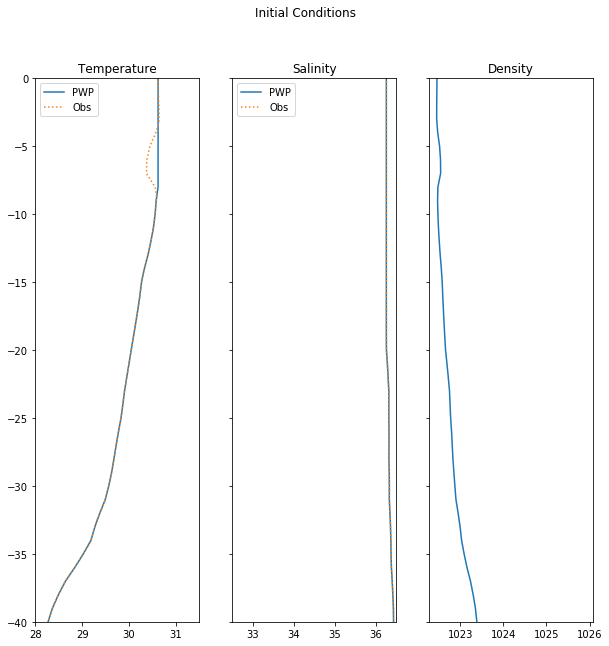

In [10]:
fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=3, sharey=True)
ax[0].plot(prep_data_out['temp'][:,0],-prep_data_out['z'], label='PWP')
ax[0].plot(IC_ds['t'],-IC_ds['z'], label='Obs', ls=':')
ax[0].set_title('Temperature')
ax[0].set_ylim((-40,0))
ax[0].set_xlim((28,31.5))
ax[0].legend()

ax[1].plot(prep_data_out['sal'][:,0],-prep_data_out['z'], label='PWP')
ax[1].plot(IC_ds['s'],-IC_ds['z'], label='Obs', ls=':')
ax[1].set_title('Salinity')
ax[1].set_xlim((32.5,36.5))
ax[1].legend()


ax[2].plot(prep_data_out['dens'][:,0],-prep_data_out['z'])
ax[2].set_title('Density')
plt.suptitle('Initial Conditions')

# Run the model

In [11]:
%%capture
pwp_out = pwp.pwpgo(forcing, params, prep_data_out, diagnostics=False);


# Make a quick plot to check the output from the model

/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


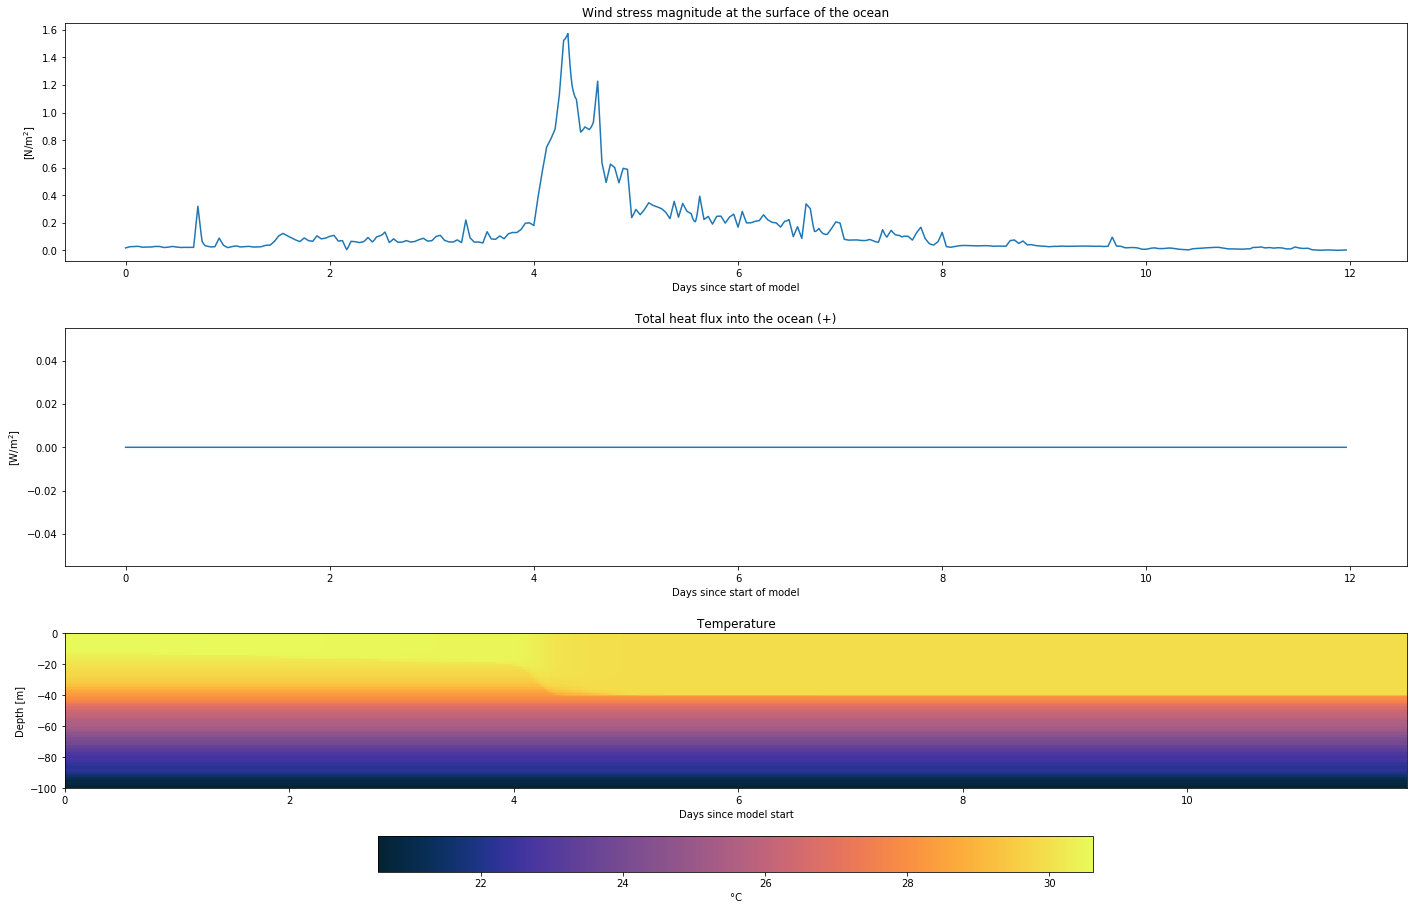

In [12]:
time_grid, depth_grid = np.meshgrid(pwp_out['time'],pwp_out['z'])

fig, ax = plt.subplots(figsize=(20,13), nrows=3, ncols=1)

# Plot wind stress and don't forget labels and titles!
ax[0].plot(forcing['time'],np.sqrt(forcing['tx']**2 + forcing['ty']**2), label='Total wind stress')
ax[0].set_title('Wind stress magnitude at the surface of the ocean')
ax[0].set_ylabel(r'[N/m$^{2}$]')
ax[0].set_xlabel('Days since start of model')

# Repeat for the heat fluxes
ax[1].plot(forcing['time'],forcing['lw']+forcing['sw']+forcing['qsens']+forcing['qlat'], label='Total')
ax[1].set_title('Total heat flux into the ocean (+)')
ax[1].set_ylabel(r'[W/m$^{2}$]')
ax[1].set_xlabel('Days since start of model')

mapp = ax[2].pcolormesh(time_grid, -depth_grid, pwp_out['temp'], cmap=cmo.thermal)
plt.colorbar(mapp, orientation='horizontal', pad=0.2, shrink=0.7, label='°C')
ax[2].set_ylabel('Depth [m]')
ax[2].set_xlabel('Days since model start')
ax[2].set_title('Temperature')

plt.tight_layout(pad=2)

# Store output as .nc

In [14]:
# Create a datenum time grid and a full depth grid because PWP only outputs time, depth vectors
pwptnum = time_grid + mdates.datestr2num(tstart) # Add back in the start datenum to put the time back into reality
pwpz = depth_grid

# Create a dictionary to organize the data
store_dict = {'time_vector': {"dims":("tnum"), "data": pwptnum[0,:]}, 
              'z_vector': {"dims":("z"), "data": np.asarray(pwp_out['z'])},
              'tgrid': {"dims":("z","tnum"), "data":pwptnum},
              'zgrid': {"dims":("z","tnum"), "data":pwpz},              
              'temp': {"dims":("z","tnum"), "data":np.asarray(pwp_out['temp'])},
              'sal':  {"dims":("z","tnum"), "data":np.asarray(pwp_out['sal'])}, 
              'dens':  {"dims":("z","tnum"), "data":np.asarray(pwp_out['dens'])},
              'uvel':  {"dims":("z","tnum"), "data":np.asarray(pwp_out['uvel'])}, 
              'vvel':  {"dims":("z","tnum"), "data":np.asarray(pwp_out['vvel'])},
              'mld': {"dims":("tnum"), "data": np.asarray(pwp_out['mld'])}}

# Convert the dictionary to an xarray dataset
store_ds = xr.Dataset.from_dict(store_dict)


# Set up filename
out_path = '/Users/coakley/Github/Ida/data/'
out_fn = case+'_pwp_'+str(dz)+'m_dz'

params
if params['winds_ON']:
    out_fn = out_fn+'_winds'
    
if params['heat_ON']:
    out_fn = out_fn+'_heat'
    
if params['drag_ON']:
    out_fn = out_fn+'_drag'
    
if out_fn[-1]=='_':
    out_fn = out_fn[:-1]
    
out_fn = out_fn+'.nc'

# Write out the dataset to a .nc
# store_ds.to_netcdf(path= out_path+out_fn,mode='w')
print(out_path+out_fn)

/Users/coakley/Github/Ida/data/altered_1629339767_HRRR_MLD1e-4_pwp_1m_dz_winds_drag.nc
